In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import math

import numpy as np
import pandas as pd
import seaborn as sns
from itertools import groupby
from IPython.display import display, HTML

from trickster.search import a_star_search
from trickster.wfp_helper import extract, load_cell

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from scipy.spatial import distance
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from defaultcontext import with_default_context
from profiled import Profiler, profiled

seed = 2018

In [4]:
def load_data(path='./data/wfp_traces/'):
    labels = []
    data = []
    for fn in tqdm_notebook(os.listdir(path)):
        file_path = path + fn
        if os.path.isfile(file_path):
            cell_list = load_cell(file_path)
            feature_list = extract(cell_list)
            if "-" in str(fn):
                labels.append(1)
                data.append((cell_list, feature_list))
            else:
                labels.append(0)
                data.append((cell_list, feature_list))
    labels = np.array(labels)
    data = np.array(data)
    return data, labels

# Load data

Load website cell traces - load both cell traces and CUMUL features for classification.

In [5]:
X, y = load_data(path='./data/wfp_traces_toy/')
X, y = X[:500], y[:500]
print("Shape of data: {}, Shape of labels: {}".format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print("Number train samples: {}, Number test samples: {}".format(X_train.shape[0], X_test.shape[0]))

X_train_cell, X_train_features = zip(*X_train)
X_test_cell, X_test_features = zip(*X_test)
X_train_cell, X_train_features = np.array(X_train_cell), np.array(X_train_features)
X_test_cell, X_test_features = np.array(X_test_cell), np.array(X_test_features)


Shape of data: (96, 2), Shape of labels: (96,)
Number train samples: 86, Number test samples: 10


# Fit logistic regression model

In [6]:
# Fit logistic regression and perform CV
clf = LogisticRegressionCV(
    Cs=21, 
    cv=5, 
    n_jobs=-1, 
    random_state=seed
)
clf.fit(X_train_features, y_train)

# Get best score and C value
mean_scores = np.mean(clf.scores_[1], axis=0)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_C = clf.Cs_[best_idx]

print('Best score is: {:.2f}%. Best C is: {:.4f}.'.format(best_score*100, best_C))
print('Test score is: {:.2f}%.'.format(clf.score(X_test_features, y_test)*100))

Best score is: 93.06%. Best C is: 0.0631.
Test score is: 90.00%.


In [7]:
@with_default_context(use_empty_init=True)
class Counter:
    def __init__(self):
        self.cnt = 0
        
    def increment(self):
        self.cnt += 1
        
    def count(self):
        return self.cnt

Define `BruteNode` class transformation code:
If at level i a node contains an input of length n, there will be n+1 branches at level i+1 with a new request at every possible index.

In [8]:
class BruteNode:
    
    def __init__(self, x):
        self.root = list(x)
    
    def expand(self):
        # Increment the counter of expanded nodes.
        counter = Counter.get_default()
        counter.increment()

        children = [ ]

        for idx in range(len(self.root) + 1):
            expanded_node = self.root[:idx] + [1] + self.root[idx:]
            children.append(np.array(expanded_node))
        
        return children
    
    def __repr__(self):
        return 'Node({})'.format(self.root)

All the functions that need to be passed into the search, in the expected format.  

In [9]:
def _expand_fn(x, p_norm=1):
    """Wrap the example in `Node`, expand the node, and compute the costs.
    
    Returns a list of tuples (child, cost)
    """
    node = BruteNode(x)
    children = node.expand()
    costs = [np.linalg.norm(
        np.array(extract(x)) - np.array(extract(c)), ord=p_norm)
             for c in children]
    return list(zip(children, costs))

def _goal_fn(x, clf, target_confidence=0.5):
    """Tell whether the example has reached the goal."""
    return clf.predict_proba([extract(x)])[0, 1] >= target_confidence

def _heuristic_fn(x, clf, q_norm=np.inf):
    """Distance to the decision boundary of a logistic regression classifier.
    
    By default the distance is w.r.t. L1 norm. This means that the denominator
    has to be in terms of the Holder dual norm (`q_norm`), so L-inf. I know,
    this interface is horrible.
    
    NOTE: The value has to be zero if the example is already on the target side
    of the boundary.
    """
    score = clf.decision_function([extract(x)])[0]
    if score >= 0:
        return 0.0
    return np.abs(score) / np.linalg.norm(clf.coef_, ord=q_norm)

def hash_fn(x):
    """Hash function for examples."""
    x_str = ''.join(str(e) for e in x)
    return hash(x_str)

In [18]:
@profiled
def find_adversarial(x, clf, p_norm=1, q_norm=np.inf,
                     target_confidence=0.5, return_path=False):
    """Transform an example until it is classified with target confidence.""" 

    if clf.predict_proba([extract(x)])[0, 1] >= target_confidence:
        raise Exception('Initial example is already classified as positive.')        
    return a_star_search(
        start_node=x, 
        expand_fn=lambda x: _expand_fn(x, p_norm=p_norm), 
        goal_fn=lambda x: _goal_fn(x, clf, target_confidence), 
        heuristic_fn=lambda x: _heuristic_fn(x, clf, q_norm=q_norm), 
        iter_lim=int(100),
        hash_fn=hash_fn,
        return_path=return_path
    )

In [15]:
def find_adv_examples(X_cells, X_features, target_confidence, p_norm=1, q_norm=np.inf):
    """Find adversarial examples for a whole dataset"""
    

    # Dataframe for storing the results.
    results = pd.DataFrame(
        columns=['index', 'found', 'confidence', 'original_confidence',
                 'real_cost', 'path_cost', 'nodes_expanded', 'runtime', 'conf_level'])

    # Indices of examples classified as negative.
    neg_indices, = np.where(clf.predict_proba(X_features)[:, 1] < target_confidence)
    
    for i, original_index in enumerate(neg_indices):
        x = X_cells[original_index]
        
        # Instantiate a counter for expanded nodes, and a profiler.
        expanded_counter = Counter()
        per_example_profiler = Profiler()
        
        with expanded_counter.as_default(), per_example_profiler.as_default():
            x_adv, path_cost = find_adversarial(
                    x, clf, target_confidence=target_confidence)

        nodes_expanded = expanded_counter.count()
        runtime = per_example_profiler.compute_stats()['find_adversarial']['tot']
        
        # If an adversarial example was not found, only record index, runtime, and 
        # the number of expanded nodes.
        if x_adv is None:
            results.loc[i] = [original_index, False, [], None,
                              None, None, nodes_expanded, runtime]
        else:
            confidence = clf.predict_proba([extract(x_adv)])[0, 1]
            original_confidence = clf.predict_proba([extract(x)])[0, 1]
            real_cost = np.linalg.norm(x_adv, ord=p_norm) - np.linalg.norm(x, ord=p_norm)
            
            results.loc[i] = [original_index, True, confidence, original_confidence,
                              real_cost, path_cost, nodes_expanded, runtime, target_confidence]

    return results

## Run the experiments  
  
Fix several target confidence levels.

In [ ]:
results_graph_1 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_1.append(find_adv_examples(X_test_cell, X_test_features, level))

for res in results_graph_1:
    display(HTML(res.to_html()))
    print()
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [16]:
confidence_levels = np.linspace(0.50, 0.95, 1)

Find adversarial examples for the whole dataset using transformation graph

### Plots

Check path cost and real cost are correlated.

In [ ]:
for res in results_graph_1:
    plt.scatter(res['real_cost'], res['path_cost'])
    
plt.xlabel('Real cost')
plt.ylabel('Path cost')
plt.show()

Success rates for crafting adversarial examples, and average confidence of these.

In [17]:
def plot_confidence(results):
    success_prop = [result['found'].mean() for result in results]
    avg_confidence = [result['confidence'].mean() for result in results]
    
    fig, ax = plt.subplots()
    ax.set_xticks(confidence_levels)
    ax.plot(confidence_levels, success_prop,
            label='Success proportion')
    ax.plot(confidence_levels, avg_confidence,
            label='Avg confidence of adversarial examples')
    ax.plot(confidence_levels, confidence_levels,
            linestyle='dashed', color='gray', label='Baseline confidence')
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('')
    plt.legend()
    plt.show()

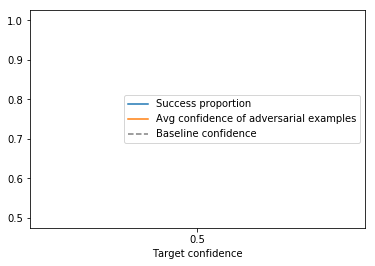

In [18]:
plot_confidence(results_graph_1)

Number of expanded nodes for graph 1 (strongly correlated with runtime)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


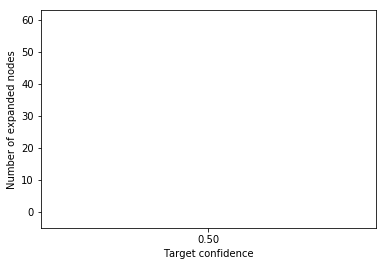

In [20]:
avg_expanded = pd.Series(
    [np.mean(result['nodes_expanded'][result['found']])
     for result in results_graph_1])
sigma_expanded = pd.Series(
    [np.std(result['nodes_expanded'][result['found']])
     for result in results_graph_1])

avg_runtime = pd.Series(
    [np.mean(result['runtime'][result['found']])
     for result in results_graph_1])

fig, ax = plt.subplots()
avg_expanded.plot(label='Number of expanded nodes', ax=ax)
ax.fill_between(range(len(confidence_levels)),
                avg_expanded - 2 * sigma_expanded,
                avg_expanded + 2 * sigma_expanded, alpha=.2)
ax.set_xticks(range(len(confidence_levels)))
ax.set_xticklabels(['%2.2f' % level for level in confidence_levels])
ax.set_xlim(0, len(confidence_levels) - 1)
ax.set_xlabel('Target confidence')
ax.set_ylabel('Number of expanded nodes')

# avg_runtime.plot(secondary_y=True, label='Avg runtime')
plt.show()